<b>Content</b>  
You are owing a supermarket mall and through membership cards , you have some basic data about your customers like Customer ID, age, gender, annual income and spending score.
Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.

<b>Problem Statement</b>   
You own the mall and want to understand the customers like who can be easily converge [Target Customers] so that the sense can be given to marketing team and plan the strategy accordingly.

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm

In [2]:
path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")
print("Files:", os.listdir(path))

csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_file))

Files: ['Mall_Customers.csv']


In [3]:
df.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


### EDA

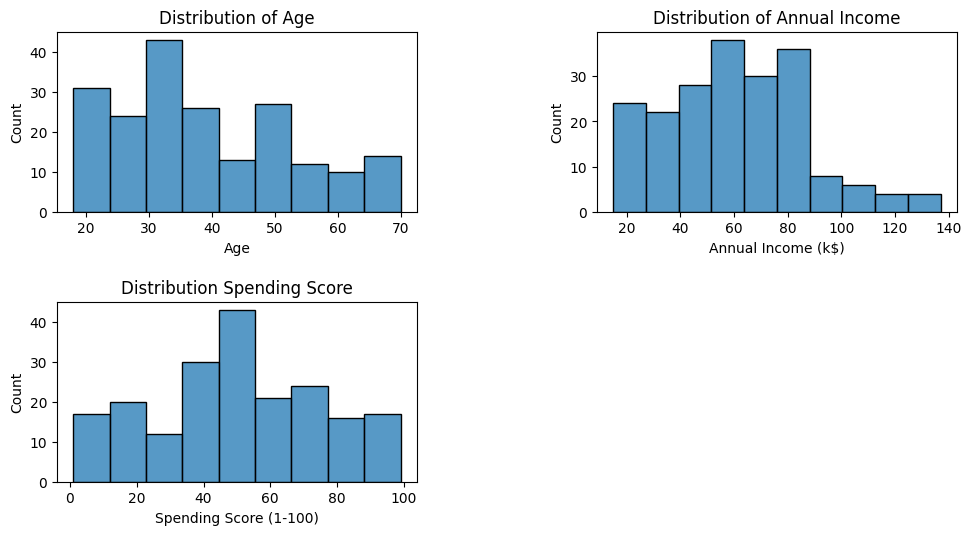

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(2,2,1)
sns.histplot(df['Age']).set(title='Distribution of Age')

plt.subplot(2,2,2)
sns.histplot(df['Annual Income (k$)']).set(title='Distribution of Annual Income')

plt.subplot(2,2,3)
sns.histplot(df['Spending Score (1-100)']).set(title='Distribution Spending Score')


plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.5, 
                    hspace=0.5)
plt.show()

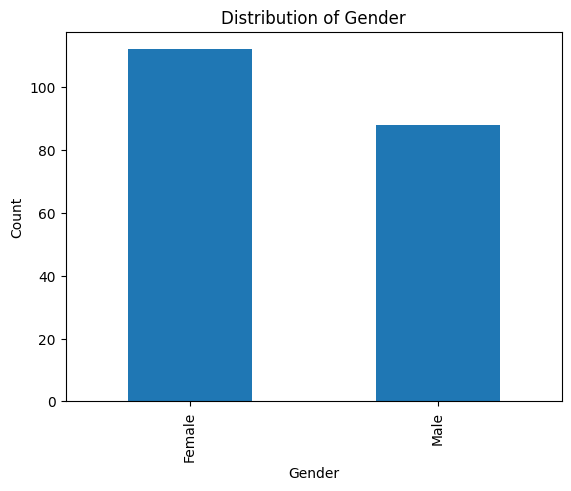

In [5]:
# Count categories
counts = df['Gender'].value_counts()

# Plot
counts.plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender')
plt.show()

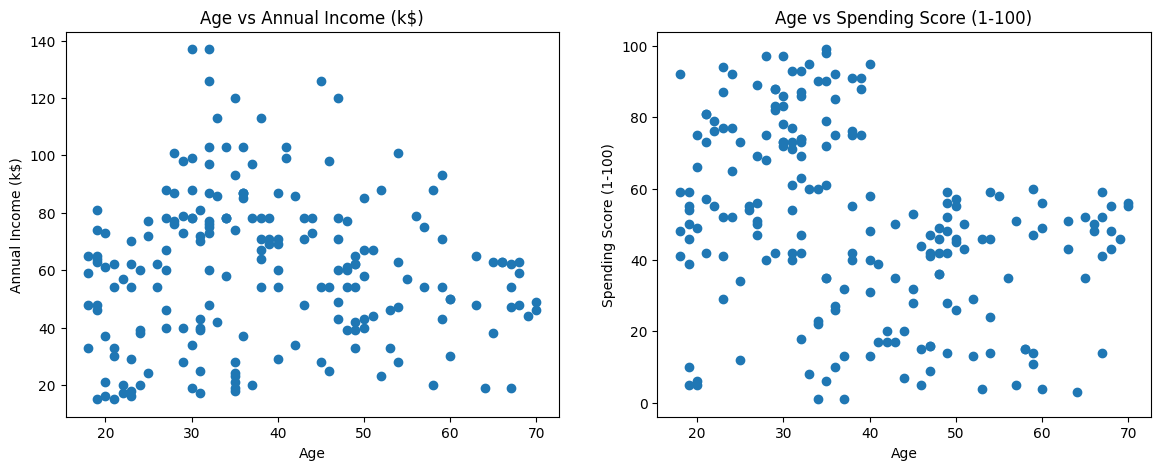

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot 1
axes[0].scatter(df['Age'], df['Annual Income (k$)'])
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Annual Income (k$)')
axes[0].set_title('Age vs Annual Income (k$)')

# plot 2
axes[1].scatter(df['Age'], df['Spending Score (1-100)'])
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Spending Score (1-100)')
axes[1].set_title('Age vs Spending Score (1-100)')


plt.show()

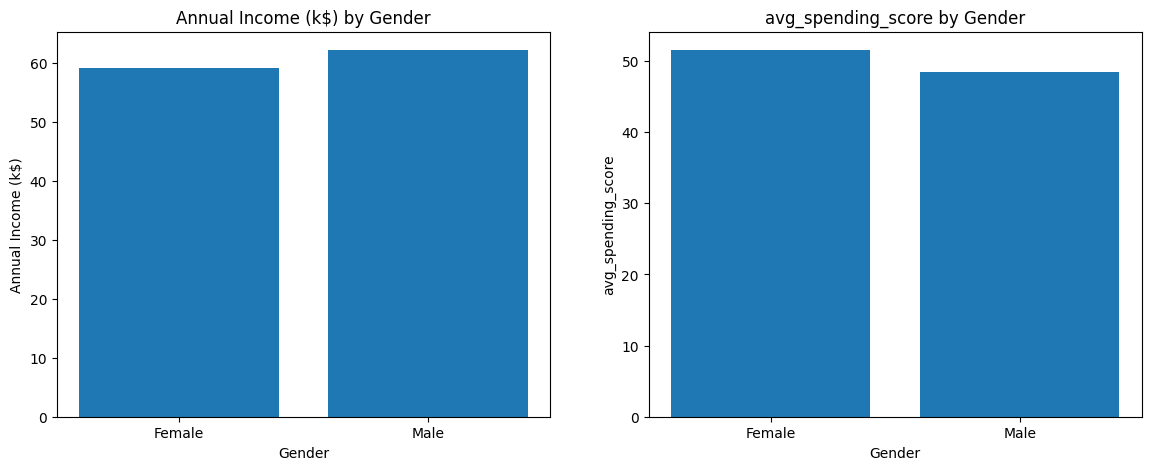

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# Aggregate (mean salary per department)
grouped = df.groupby('Gender', as_index=False)['Annual Income (k$)'].mean().rename(columns={'Annual Income (k$)': 'avg_annual_salary'})

# Plot
axes[0].bar(grouped['Gender'], grouped['avg_annual_salary'])
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Annual Income (k$)')
axes[0].set_title('Annual Income (k$) by Gender')

# Aggregate (mean salary per department)
grouped = df.groupby('Gender', as_index=False)['Spending Score (1-100)'].mean().rename(columns={'Spending Score (1-100)': 'avg_spending_score'})

# Plot
axes[1].bar(grouped['Gender'], grouped['avg_spending_score'])
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('avg_spending_score')
axes[1].set_title('avg_spending_score by Gender')



plt.show()

### Scale Data

In [8]:
cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
df = df[cols]

sc = StandardScaler()
sc.fit(df)

scaled_df = sc.transform(df)

## Find the Optimal K

### Elbow method

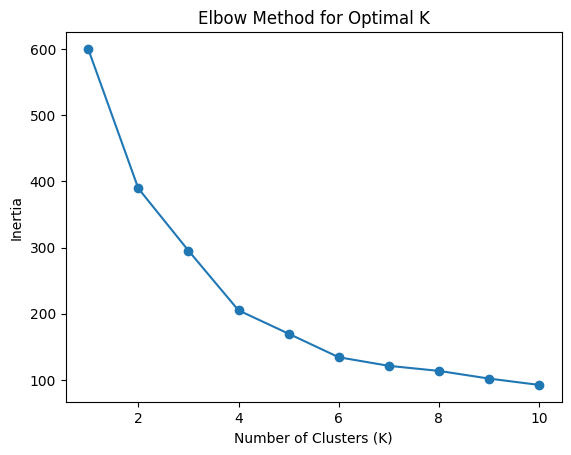

In [9]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

### Silhouette Score Method

K=2, Silhouette Score=0.3355
K=3, Silhouette Score=0.3579
K=4, Silhouette Score=0.4040
K=5, Silhouette Score=0.4085
K=6, Silhouette Score=0.4311
K=7, Silhouette Score=0.4101
K=8, Silhouette Score=0.3674
K=9, Silhouette Score=0.3744
K=10, Silhouette Score=0.3619


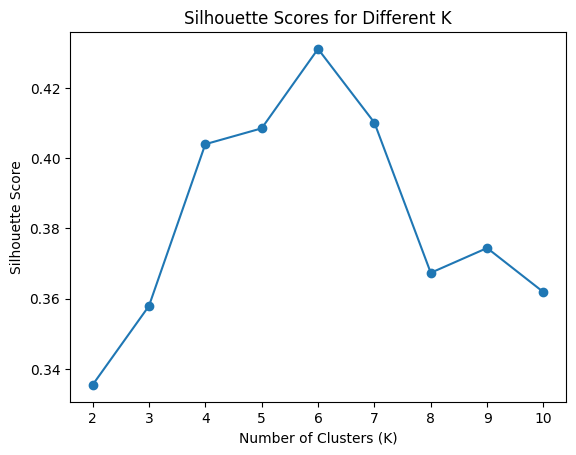

In [10]:
# Example scaled dataframe: scaled_df
k_range = range(2, 11)  # start from 2
scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_df)
    score = silhouette_score(scaled_df, labels)
    scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

# Plot
plt.plot(k_range, scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different K')
plt.show()

<b> The optimal number of clusters is 6 </b>

In [11]:
# Training the model with optimal no of clusters
kmeans = KMeans(n_clusters=6,init='k-means++',random_state=1000)
labels = kmeans.fit_predict(scaled_df)

C:\Users\syarn\AppData\Local\Temp\ipykernel_31460\3546621768.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')  # supports up to 10 distinct colors


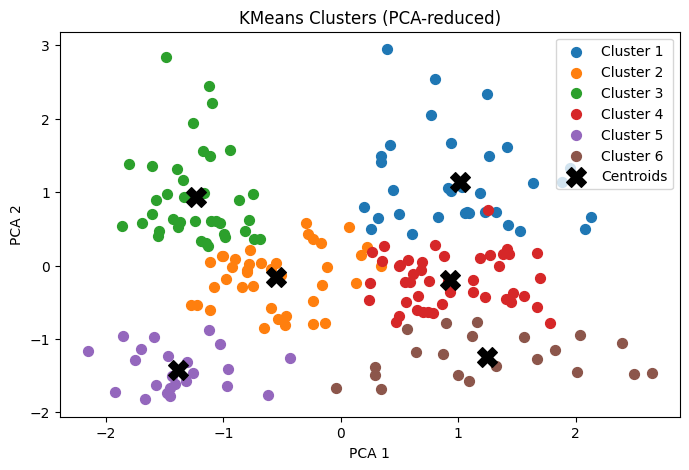

In [12]:
# PCA reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_df)

plt.figure(figsize=(8,5))

# Choose a colormap
cmap = cm.get_cmap('tab10')  # supports up to 10 distinct colors

# Only add labels for clusters that exist in data
for i in range(k):
    cluster_points = X_pca[labels == i]
    if len(cluster_points) > 0:  # only plot if cluster has points
        plt.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            s=50,
            color=cmap(i),
            label=f'Cluster {i+1}'
        )

# Plot centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    s=200,
    c='black',
    marker='X',
    label='Centroids'
)

plt.title('KMeans Clusters (PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

<b> The analysis indicates 6 as the optimal number of clusters, so we segment the customers into six groups. </b>

In [13]:
# Add cluster labels to data
df['Cluster'] = labels
display(df.head(5))

,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,19,15,39,4
1,21,15,81,4
2,20,16,6,5
3,23,16,77,4
4,31,17,40,5
